# Planning pattern

When faced with complex, multi-step problems, an AI agent benefits from thinking ahead before acting. Just as humans plan their approach to large projects by breaking them into smaller tasks, AI agents can do the same through the planning pattern.

The planning pattern is an agentic design approach where the agent first generates an explicit plan - a structured breakdown of the task into smaller, manageable steps - before executing any actions. Instead of immediately jumping into tool calls or producing output, the agent pauses to think strategically: What are the sub-goals? What order makes sense? What dependencies exist between steps? This pattern is particularly valuable for:
- Complex tasks requiring multiple coordinated steps.
- Problems where the order of operations matters.
- Situations where we want transparency into the agent's reasoning process.
- Tasks that benefit from upfront decomposition before execution.

In this notebook, we will implement a planning-based agent that:
1. Receives a user request.
2. Generates a structured plan breaking the task into steps.
3. Executes each step in sequence.
4. Returns the final result.

This approach gives us visibility into how the agent thinks and allows for better error handling, progress tracking, and the ability to modify plans dynamically if needed.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated, List
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import math
import json

### Initialize the language model

The language model serves as the intelligence behind both our planning and execution phases. We need a model capable of strategic thinking for plan generation and precise execution for carrying out those plans.

In [2]:
# Initialize the OpenAI language model
# Using temperature=0 for consistent, deterministic planning
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

We use `temperature=0.0` to ensure our agent produces consistent plans for similar tasks. This is especially important in planning scenarios where we want reproducible, logical step decomposition rather than creative variation.

### Define the agent state
In the planning pattern, we need to track more than just the conversation history. We also need to store the generated plan itself and keep track of which steps have been completed. This allows us to maintain context throughout the planning and execution cycle, ensuring each step builds on previous results.

Our state will include the conversation messages, the plan (as a list of steps), and a field to track execution results. This structured state enables the agent to reference its own plan during execution and helps us understand exactly what the agent is doing at each stage.

In [3]:
# Define a dictionary structure for the agent's state throughout the planning workflow
class PlanningState(TypedDict):
    """State that tracks both conversation and planning information."""
    # The `messages` field stores the conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The `plan` field stores the structured plan as a list of steps
    plan: List[str]
    # The `current_step` field tracks which step we are currently executing
    current_step: int

The `PlanningState` extends our typical conversation state with planning-specific fields. 
- The `messages` list maintains full conversation context using LangGraph's `add_messages` reducer to append new messages.
- The `plan` field will hold our structured list of steps.
- The `current_step` helps us iterate through execution.

This separation of concerns makes the workflow more maintainable and allows us to inspect or modify the plan at any point.

### Define tools
Even though this is a planning-focused pattern, the agent still needs actual capabilities to execute its plans. We provide the same set of tools we have used before - Wikipedia for information retrieval and a calculator for mathematical operations. These tools will be called during the execution phase, after the plan has been formulated.

#### Wikipedia search tool

In [4]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for the query and return a brief summary of the top result."""
    try:
        # Fetches summary from Wikipedia for the given query (limited to 5 sentences)
        summary = wikipedia.summary(query, sentences=5)
        return summary
    except Exception as e:
        # Return error if the query fails (e.g., disambiguation, page not found)
        return f"Error: {e}"

The Wikipedia tool allows our agent to gather factual information during plan execution. The `@tool` decorator exposes this to the LLM with its docstring as the description.

#### Calculator tool

In [5]:
@tool
def calculator(expression: str) -> str:
    """Safely evaluate a basic mathematical expression (e.g., '2 + 2 * 5')."""
    try:
        # Use eval in a restricted environment — no access to Python built-ins
        result = eval(expression, {"__builtins__": {}}, {"math": math})
        return str(result)
    except Exception as e:
        # Return error message if evaluation fails
        return f"Error: {e}"

The calculator provides computational capabilities in a sandboxed environment. We restrict the evaluation context to prevent security issues while still allowing mathematical operations.

#### Bind tools to the model
We create a tools registry and bind them to the model.

In [6]:
# Collect tools into a list
tools = [wiki_search, calculator]
# Build a name → tool dictionary for runtime execution
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to the LLM (so it knows what capabilities are available)
llm_with_tools = llm.bind_tools(tools)

The `tools_by_name` dictionary enables quick tool lookup during execution, while `bind_tools()` informs the LLM about available capabilities so it can reference them in its plan and execution steps.

### Create nodes

#### Create planning node
The planning node is the heart of this pattern. This is where the agent analyzes the user's request and generates a structured, step-by-step plan to accomplish the goal. Rather than jumping straight into action, the agent takes time to think strategically about the best approach. The planner considers what information is needed, what order makes sense, and how to break down the complex task into manageable pieces. This upfront planning investment pays off by making execution more organized and transparent.

In [7]:
def planning_node(state: PlanningState):
    """Generate a structured plan to solve the user's request."""
    
    # System prompt guides the agent to create a detailed plan
    system_prompt = SystemMessage(
        content="""You are a planning assistant. Given a user request, break it down into a clear, 
        step-by-step plan. Each step should be actionable and specific. 
        
        Available tools:
        - wiki_search: Search Wikipedia for information
        - calculator: Perform mathematical calculations
        
        Format your plan as a numbered list where each line starts with a step number.
        Example:
        1. Search for population data
        2. Extract the relevant number
        3. Perform the calculation
        """
    )
    
    # Get the user's original question from messages
    user_message = state["messages"][0]
    
    # Ask the LLM to create a plan
    response = llm.invoke([system_prompt, user_message])
    
    # Parse the plan from the response content
    # Split by lines and extract steps (lines starting with numbers)
    plan_text = response.content
    plan_steps = []
    for line in plan_text.split('\n'):
        # Look for lines that start with a number followed by a period or parenthesis
        line = line.strip()
        if line and line[0].isdigit():
            # Remove the number prefix and add to plan
            step = line.split('.', 1)[-1].strip() if '.' in line else line.split(')', 1)[-1].strip()
            if step:
                plan_steps.append(step)
    
    # Add the plan message to conversation history
    plan_message = AIMessage(content=f"Plan created:\n{plan_text}")
    
    # Return updated state with the plan and plan message
    return {
        "messages": [plan_message],
        "plan": plan_steps,
        "current_step": 0
    }

This node receives the user's request and generates a structured plan. The system prompt explicitly instructs the LLM to think in terms of discrete, actionable steps and to format them as a numbered list. We then parse this formatted response to extract individual steps into a list structure. The parsed plan is stored in the state's `plan` field, making it available for the execution phase. We also add the full plan text as an AI message to maintain transparency - the user can see exactly what the agent is planning to do.

#### Create execution node
Once we have a plan, we need to execute it. The execution node is responsible for carrying out the planned steps one by one. It reads the current step from the plan, interprets what needs to be done, and either calls the appropriate tool or performs the required reasoning. This node embodies the "do" phase of the plan-then-do workflow, turning our strategic plan into concrete actions and results.

In [8]:
def execution_node(state: PlanningState):
    """Execute the steps from the plan using available tools."""
    
    # Get the current step from the plan
    current_step_idx = state["current_step"]
    plan = state["plan"]
    
    # Check if we've completed all steps
    if current_step_idx >= len(plan):
        # All steps done - generate final answer
        system_prompt = SystemMessage(
            content="Based on all the information gathered, provide a final comprehensive answer to the user's question."
        )
        response = llm.invoke([system_prompt] + list(state["messages"]))
        return {"messages": [response]}
    
    # Get the current step description
    current_step = plan[current_step_idx]
    
    # Create a prompt to execute this specific step
    system_prompt = SystemMessage(
        content=f"""You are executing step {current_step_idx + 1} of a plan: '{current_step}'
        
        Use the available tools if needed to complete this step. Be specific and focused on just this step.
        """
    )
    
    # Execute the step with tool access
    response = llm_with_tools.invoke([system_prompt] + list(state["messages"]))
    
    # Check if tools were called and execute them
    new_messages = [response]
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Execute each tool call
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Run the tool if available
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."
            
            # Create a message with the tool result
            tool_message = ToolMessage(
                content=json.dumps(result),
                name=tool_name,
                tool_call_id=tool_call.get("id")
            )
            new_messages.append(tool_message)
    
    # Increment the step counter
    return {
        "messages": new_messages,
        "current_step": current_step_idx + 1
    }

The execution node operates in a loop, processing one plan step at a time. It tracks progress using the `current_step` index, fetching the corresponding step description from the plan. For each step, we create a focused system prompt that tells the LLM exactly which step to execute. The LLM then decides whether it needs tools to complete that step and makes the appropriate calls. After executing any tool calls, we increment the step counter and return the updated state. When all steps are complete (`current_step >= len(plan)`), the node generates a final synthesized answer based on all accumulated information.

### Define routing logic
To create a proper iterative workflow, we need logic that determines when to continue executing plan steps versus when to stop. This routing decision is based on whether there are still unexecuted steps remaining in the plan. As long as steps remain, we continue the execution loop; once all steps are done, we terminate the workflow.

In [9]:
def should_continue(state: PlanningState) -> str:
    """Determine if we should continue executing steps or finish."""
    # Check if there are more steps to execute
    if state["current_step"] < len(state["plan"]):
        return "continue"  # More steps remain
    else:
        return "end"  # All steps completed

This simple but crucial function compares our progress (`current_step`) against the total number of steps in the plan. If steps remain, we route back to the execution node for another iteration. If all steps are complete, we route to the END state, finalizing the workflow.

### Build the agent graph
Now we assemble all the pieces into a cohesive workflow using LangGraph. Our graph follows a clear sequence: planning first, then iterative execution of each step, and finally termination once all steps are complete. This structure makes the planning pattern's logic explicit and easy to follow.

In [10]:
# Build the planning workflow graph
graph = StateGraph(PlanningState)

# Add nodes for each phase
graph.add_node("planner", planning_node)  # Generate the plan
graph.add_node("executor", execution_node)  # Execute plan steps

# Define the workflow edges
graph.add_edge(START, "planner")  # Start by creating a plan
graph.add_edge("planner", "executor")  # After planning, begin execution

# Add conditional edge for the execution loop
graph.add_conditional_edges(
    "executor",  # From the executor node
    should_continue,  # Check if more steps remain
    {
        "continue": "executor",  # Loop back for the next step
        "end": END,  # All steps done, terminate
    },
)

# Compile the graph into a runnable agent
agent = graph.compile()

The graph construction follows the planning pattern's natural flow. We start at the `planner` node which creates our structured plan. From there, we move unconditionally to the `executor` node. The executor then enters a conditional loop controlled by `should_continue` - it keeps executing steps until the plan is exhausted, at which point it exits to END. This creates a clean plan-then-execute-iteratively workflow.

#### Visualize the workflow

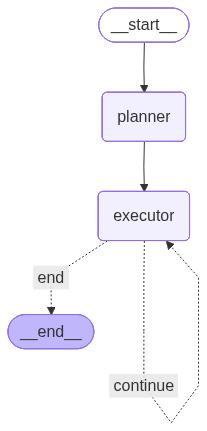

In [11]:
# Visualize the graph structure
display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run an example

Let's see the planning pattern in action with a multi-step question that requires both information retrieval and calculation. This will demonstrate how the agent first plans its approach, then systematically executes each step.

In [15]:
# Example: A complex query requiring planning
user_question = "What is the population of Israel in 2025, and what would that be divided by 3?"

# Initialize state with the user's question
initial_state = PlanningState(
    messages=[HumanMessage(content=user_question)],
    plan=[],
    current_step=0
)

# Run the planning agent
result = agent.invoke(initial_state)

# Display the results
print("=== Planning Pattern Execution ===")
print(f"\nUser Question: {user_question}\n")

# Show the generated plan
print("Generated Plan:")
for i, step in enumerate(result["plan"], 1):
    print(f"  {i}. {step}")

print("\n=== Execution Trace ===")
# Print all messages to see the execution flow
for msg in result["messages"]:
    print(f"\n{msg.type.upper()}: {msg.content[:200]}...") if len(msg.content) > 200 else print(f"\n{msg.type.upper()}: {msg.content}")

=== Planning Pattern Execution ===

User Question: What is the population of Israel in 2025, and what would that be divided by 3?

Generated Plan:
  1. Search for the projected population of Israel in 2025 on Wikipedia.
  2. Extract the relevant population number for Israel in 2025.
  3. Use the calculator to divide the population number by 3.

=== Execution Trace ===

HUMAN: What is the population of Israel in 2025, and what would that be divided by 3?

AI: Plan created:
1. Search for the projected population of Israel in 2025 on Wikipedia.
2. Extract the relevant population number for Israel in 2025.
3. Use the calculator to divide the population number...

AI: 

TOOL: "The demographics of Israel, monitored by the Israel Central Bureau of Statistics, encompass various attributes that define the nation's populace. Since its establishment in 1948, Israel has witnessed...

AI: 

TOOL: "3280666.6666666665"

AI: The projected population of Israel in 2025 is approximately 9,842,000. When d

In this example, the agent first creates a plan that breaks down the question into discrete steps: searching for population data, extracting the number, and performing the division. It then executes each step systematically, using Wikipedia to get the information and the calculator to perform the math. The output shows both the plan itself and the complete execution trace, making the agent's reasoning process transparent and debuggable.